# Modules for Asset Pricing Model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from jupyterthemes import jtplot
jtplot.style(theme='grade3')
from scipy.stats import norm

## Kernel_density

In [2]:
def plot_kernel_density(min_x, max_x, bin_length, data):
    
    num_hist = int((max_x - min_x) / bin_length) + 2
    initial_point = min_x - bin_length/2
    end_point = max_x + bin_length/2
    row_index = np.linspace(initial_point, end_point, num_hist)
    m = len(data)
    data = pd.Series(data)
    kernel_density = pd.Series(index = row_index)
    kernel_density.iloc[0] = len(data.where(data < min_x).dropna()) / m / bin_length # first bin
    kernel_density.iloc[-1] = len(data.where(max_x <= data).dropna()) / m / bin_length # last bin
    for i in range(num_hist-2): # other bins
        start = min_x + i * bin_length
        a = data.where(start <= data).dropna()
        a = a.where(data < start + bin_length)
        kernel_density.iloc[i+1] = len(a.dropna()) / m / bin_length
        
    return kernel_density, row_index

### Example

In [3]:
data = np.random.randn(1000)
print(data[:5])

[ 0.12375564  1.28826672  0.74708749 -0.52447433 -0.59854709]


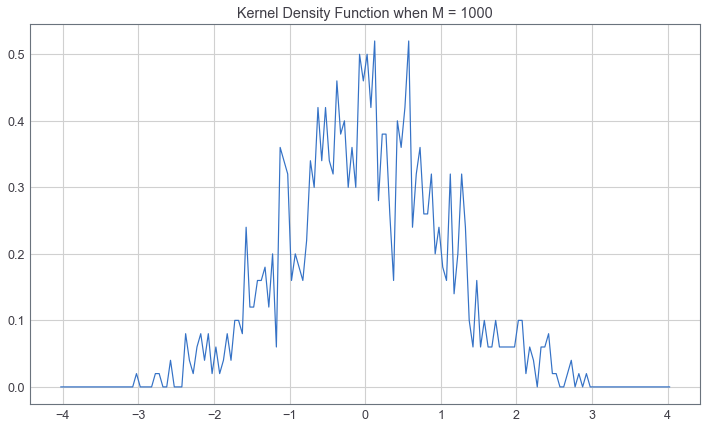

In [4]:
d = plot_kernel_density(-4,4,0.05,data)
plt.figure(figsize=(12,7))
plt.plot(d[0])
plt.title("Kernel Density Function when M = " + str(len(data)))
plt.show()

## Q-Q Plot

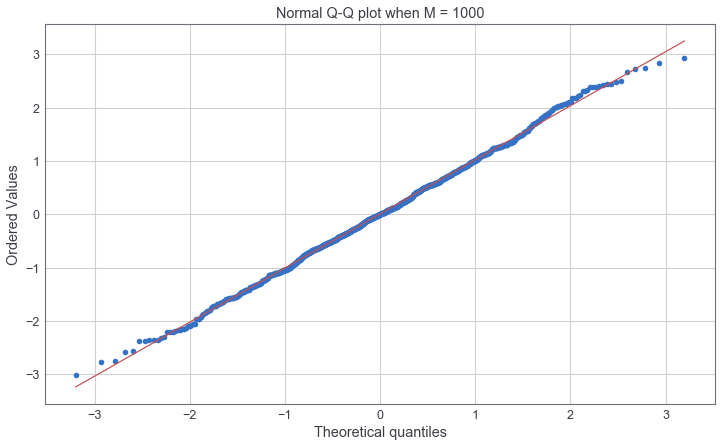

In [5]:
plt.figure(figsize=(12,7))
# Q-Q plot generating for test data set
stats.probplot(data, dist="norm", plot=plt)
plt.title("Normal Q-Q plot when M = " + str(len(data)))
plt.show()

## Graph Generating Function

In [6]:
# Function get_random_plot : making one sample graph for input parameters
def get_random_plot(S_0, mu, sigma, dt, time_line):
    s = []
    s.append(S_0)
    k = len(time_line)
    for i in range(1,k):
        s.append(s[i-1] * np.exp( (mu-0.5 * sigma ** 2) * dt + sigma * dt ** 0.5 * np.random.randn()))
    return pd.Series(s, index = time_line)

#### Setting Parameters

In [7]:
S_0 = 1
mu = 0.05
sigma = 0.5
T_0 = 0 # starting time point
T = 1 # End of time point
L = 100 # number of time_step interval
time_line = np.linspace(T_0,T,L)
dt = (T - T_0) / L # unit size of time_step interval

### iteration test

In [8]:
def iteration(iter_num):
    sample_table = pd.DataFrame()
    plt.figure(figsize=(12,7))
    # Plot M sample graphs
    for j in range(iter_num):
        sample_graph = get_random_plot(S_0, mu, sigma, dt, time_line)
        sample_table['graph' + str(j+1)] = sample_graph
        fig = plt.plot(sample_graph)
    plt.title("Sample Graphs when M = " + str(iter_num))
    plt.show()
    
    # Plot a Kernel Density for stock price at time T
    data = sample_table.iloc[-1] # iloc[-1] means 'at time T'
    
    # Set the interval to min and max value, and bin = 0.05
    kernel_density = plot_kernel_density(data.min(),data.max(),0.05,data)
    plt.figure(figsize=(12,7))
    plt.plot(kernel_density[0], label = 'Kernel Density for Paths')
    plt.title("Kernel Density Function when M = " + str(iter_num))
        
    # Plot lognormal function
    x = kernel_density[1] # get the x-axis
    x = x[np.where(x>0)] # otherwise log(x) is not defined
    
    # We should change mu and sigma for the lognormal distribution parameters
    log_mu = (mu-sigma**2 * 0.5) * T
    log_sigma = sigma * T ** 0.5
    # Plot lognormal density function on x_axis
    pdf = (np.exp(-(np.log(x) - log_mu)**2 / (2 * log_sigma**2)) / (x * log_sigma * np.sqrt(2 * np.pi)))
    plt.plot(x,pdf, label='Following Lognormal')
    plt.legend()
    plt.show()
    
    # Generating Q-Q plot
    plt.figure(figsize=(12,7))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot when M = " + str(iter_num))
    plt.show()

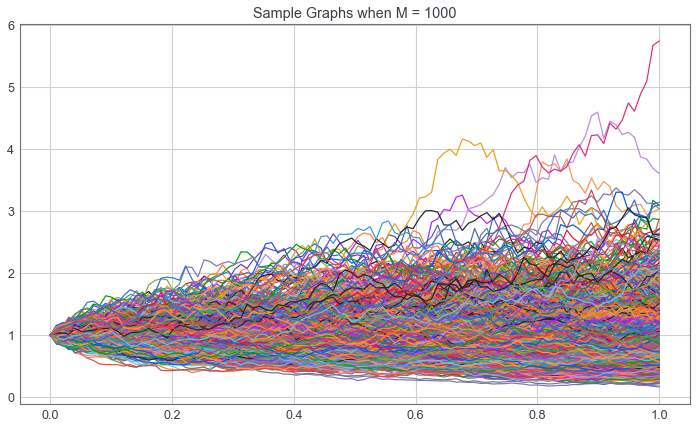

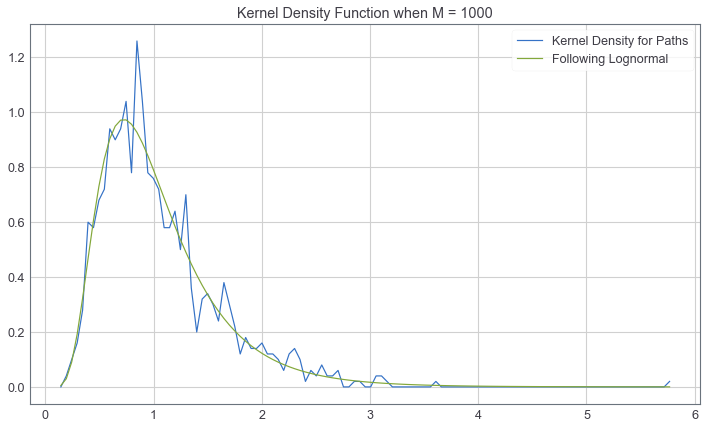

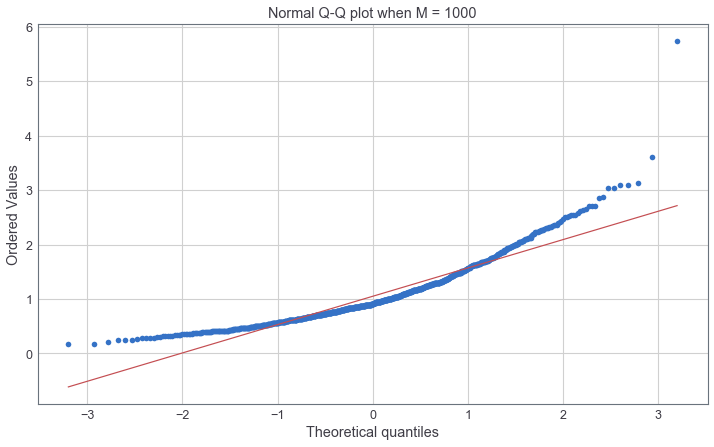

In [9]:
iteration(1000)

## B-S call & put

In [12]:
def bs_call_put(Rate, Price, Strike, Time, sigma):
    
    d1 = (np.log(Price/Strike) + (Rate + 0.5 * sigma * sigma)*Time)/(sigma*np.sqrt(Time));
    d2 = d1 - sigma * np.sqrt(Time);
    Call_Price = Price * norm.cdf(d1) - Strike * np.exp(-Rate * Time) * norm.cdf(d2);
    Put_Price = -Price * norm.cdf(-d1) + Strike * np.exp(-Rate * Time) * norm.cdf(-d2);
    CDelta = norm.cdf(d1);
    PDelta = norm.cdf(d1) - 1;
    
    return Call_Price, CDelta, Put_Price, PDelta

### Hedging simulation

In [11]:
np.linspace(1,10,5)

array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])

In [12]:
Rate = 0.05
Price = 100
Strike = 100
T = 0.25
sigma = 0.35
mu = 0.055

In [13]:
Dt = T/250
N = int(T/Dt)
t = np.linspace(0,T,N+1)

In [14]:
S = np.zeros(N)
Delta = np.zeros(N)
cash = np.zeros(N)
Hedging_portfolio = np.zeros(N)
Option_Value = np.zeros(N)

In [15]:
(C, Cdelta, P, Pdelta) = bs_call_put(Rate, Price, Strike, T, sigma)
S[0] = Price
Delta[0] = Cdelta
cash[0] = C - Delta[0] * S[0] 
Hedging_portfolio[0] = Delta[0] * S[0] + cash[0]
Option_Value[0] = C

In [16]:
for i in range(N-1):
    S[i+1] = S[i] * np.exp( (mu - 0.5 * sigma * sigma ) * Dt + sigma * np.sqrt(Dt) * np.random.randn())
    (C, Cdelta, P, Pdelta) = bs_call_put(Rate, S[i+1], Strike, T-t[i+1], sigma)
    Delta[i+1] = Cdelta
    cash[i+1] = cash[i] * (1 + Rate * Dt) - (Delta[i+1] - Delta[i]) * S[i+1]
    
    Hedging_portfolio[i+1] = Delta[i+1] * S[i+1] + cash[i+1]
    Option_Value[i+1] = C

In [17]:
Ad_Option_Value = Option_Value + (Hedging_portfolio[1] - Option_Value[1]) * np.exp(Rate * t[:-1])

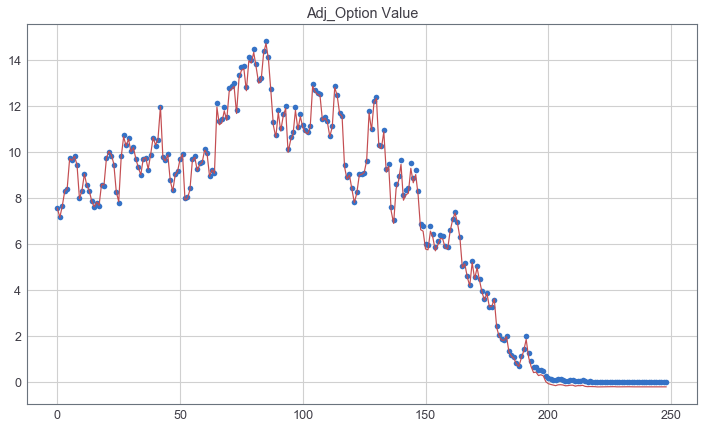

In [18]:
plt.figure(figsize=(12,7))
plt.plot(Ad_Option_Value[:-1],'bo')
plt.plot(Hedging_portfolio[:-1],'r-')
plt.title("Adj_Option Value")
plt.show() 

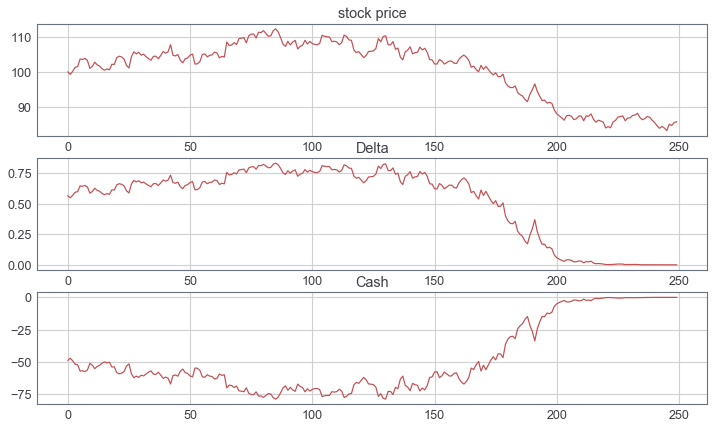

In [19]:
plt.figure(figsize=(12,7))
plt.subplot(3,1,1)
plt.plot(S, 'r')
plt.title('stock price')

plt.subplot(3,1,2)
plt.plot(Delta, 'r')
plt.title('Delta')

plt.subplot(3,1,3)
plt.plot(cash, 'r')
plt.title('Cash')

plt.show()

# Monte Carlo Method

## For Call option

In [20]:
Rate = 0.06
Price = 10
Strike = 9
Time = 1
sigma = 0.1
bs_call_put(Rate, Price, Strike, Time, sigma)[0] # True_value

1.5429374445144521

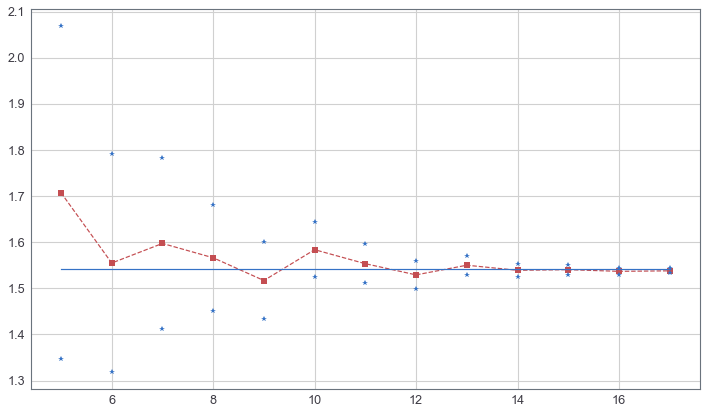

In [21]:
M = 2 ** (np.array(range(13)) + 5)
Exp = np.array(range(13)) + 5
true_value = np.ones(13) * bs_call_put(Rate, Price, Strike, Time, sigma)[0] # Calculated B-S Call Option Value

V_ave = []
V_se = []
for i in M:
    
    S = Price * np.exp((Rate - 0.5 * sigma * sigma ) * Time + sigma * np.sqrt(Time) * np.random.randn(i))
    diff = S - Strike
    diff[np.where(diff<0)] = 0
    V = np.exp(-Rate * Time) * diff
      
    V_ave.append(V.mean())
    V_se.append(V.std()/np.sqrt(i))
    

V_ave = np.array(V_ave)
V_se = np.array(V_se)

plt.figure(figsize=(12,7))
plt.plot(Exp, V_ave, '--rs')
plt.plot(Exp, V_ave + 1.96*V_se, '*b')  # 95% CI
plt.plot(Exp, V_ave - 1.96*V_se, '*b')  # 95% CI
plt.plot(Exp, true_value)
plt.show() 

#### For 문 하나 없애기

In [22]:
a = pd.Series(np.ones(10))
a.apply(lambda x : x * np.random.randn())

0    0.440919
1   -1.318581
2   -0.968790
3   -0.572467
4    0.905019
5    0.054345
6   -1.499005
7    0.777622
8    0.677807
9   -0.761288
dtype: float64

In [23]:
S = Price * np.exp((Rate - 0.5 * sigma * sigma ) * Time + sigma * np.sqrt(Time) * np.random.randn(10))
S

array([ 9.42409584,  9.68730943, 10.38191245,  9.29632388,  7.53106976,
       10.44336044,  9.92738592,  9.95008161, 10.05088916, 11.97275555])

In [24]:
S - Strike

array([ 0.42409584,  0.68730943,  1.38191245,  0.29632388, -1.46893024,
        1.44336044,  0.92738592,  0.95008161,  1.05088916,  2.97275555])

In [25]:
diff = S - Strike
diff[np.where(diff<0)] = 0
diff

array([0.42409584, 0.68730943, 1.38191245, 0.29632388, 0.        ,
       1.44336044, 0.92738592, 0.95008161, 1.05088916, 2.97275555])

In [26]:
V = np.exp(-Rate * Time) * diff
V

array([0.39939842, 0.64728365, 1.30143614, 0.27906733, 0.        ,
       1.35930567, 0.87337917, 0.89475316, 0.98969014, 2.79963575])

In [27]:
V.mean()

0.9543949418656015

In [28]:
V.std()

0.7395908297366417

In [29]:
a = np.array([1,2,3,-1,-1])
a

array([ 1,  2,  3, -1, -1])

In [30]:
a[np.where(a<0)] = 0

In [31]:
a

array([1, 2, 3, 0, 0])

# Homework 6

## Cash or Nothing Option

### Make 'bs_cash_or_nothing' function using the formula

###  $C^{cash}(S,t) = Ae^{-r(T-t)}N(d_{2})$

###  $P^{cash}(S,t) = Ae^{-r(T-t)}(1-N(d_{2}))$

<img src = 'https://trello-attachments.s3.amazonaws.com/5b29ec749cfb0d90ada47d03/5beedfbcc254ef85f1b46b5d/f410213f9d9bbf93275555d80e63c4e7/image.png'>

In [3]:
def bs_cash_or_nothing(Rate, Price, Strike, Time, sigma, pay_off): # pay_off = A for cash or nothing option
    
    d1 = (np.log(Price/Strike) + (Rate + 0.5 * sigma * sigma)*Time)/(sigma*np.sqrt(Time));
    d2 = d1 - sigma * np.sqrt(Time);
    Cash_Call_Price = pay_off * np.exp(-Rate * (Time)) * norm.cdf(d2)
    Cash_Put_Price = pay_off * np.exp(-Rate * (Time)) * (1-norm.cdf(d2))
    Call_delta = pay_off * np.exp(-Rate * (Time)) * norm.pdf(d2) / (sigma*Price*np.sqrt(Time))
    # Put_delta = 나중에 추가
    return Cash_Call_Price, Cash_Put_Price, Call_delta

### Parameter setting

In [4]:
mu = 0.03
Rate = 0.05
Price = 10
Strike = 10
Time = 1
sigma = 0.35
pay_off = 1 # Arbitrary put the pay_off, i.e. A = 1 for cash or nothing option

### $I.\: \: \mu = r$ case

For Call Cash or Nothing Option

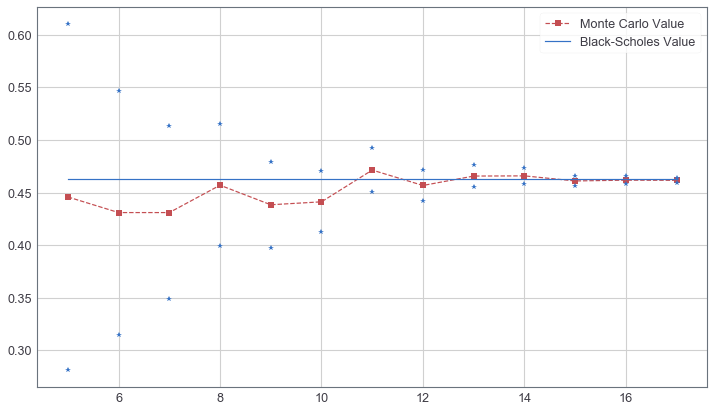

In [5]:
M = 2 ** (np.array(range(13)) + 5)
Exp = np.array(range(13)) + 5
# Calculate B-S Call Cash or Nothing Option Value
true_value = np.ones(13) * bs_cash_or_nothing(Rate, Price, Strike, Time, sigma, pay_off)[0] 

V_ave = []
V_se = []
for i in M:
    
    S = Price * np.exp((Rate - 0.5 * sigma * sigma ) * Time + sigma * np.sqrt(Time) * np.random.randn(i))
    diff = S - Strike
    diff[np.where(diff==0)] = pay_off / 2
    diff[np.where(diff<0)] = 0
    diff[np.where(diff>0)] = pay_off
    V = np.exp(-Rate * Time) * diff
      
    V_ave.append(V.mean())
    V_se.append(V.std()/np.sqrt(i))
    

V_ave = np.array(V_ave)
V_se = np.array(V_se)

plt.figure(figsize=(12,7))
plt.plot(Exp, V_ave, '--rs', label = 'Monte Carlo Value')
plt.plot(Exp, V_ave + 1.96*V_se, '*b' )
plt.plot(Exp, V_ave - 1.96*V_se, '*b')
plt.plot(Exp, true_value, label='Black-Scholes Value')
plt.legend()
plt.show() 

- Converges to Black Scholes Value

### $II.\: \: \mu \neq r$ case (Homework 6 Problem)

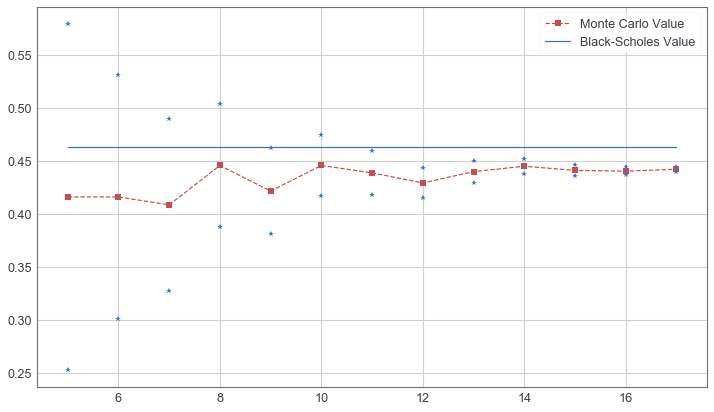

Black-Scholes Value :  0.4634190597240727
Monte Carlo Value :  0.4423472281049158


In [6]:
M = 2 ** (np.array(range(13)) + 5)
Exp = np.array(range(13)) + 5
# Calculate B-S Call Cash or Nothing Option Value
true_value = np.ones(13) * bs_cash_or_nothing(Rate, Price, Strike, Time, sigma, pay_off)[0] 

V_ave = []
V_se = []
for i in M:
    
    S = Price * np.exp((mu - 0.5 * sigma * sigma ) * Time + sigma * np.sqrt(Time) * np.random.randn(i))
    diff = S - Strike
    diff[np.where(diff==0)] = pay_off / 2
    diff[np.where(diff<0)] = 0
    diff[np.where(diff>0)] = pay_off
    V = np.exp(-Rate * Time) * diff
      
    V_ave.append(V.mean())
    V_se.append(V.std()/np.sqrt(i))
    

V_ave = np.array(V_ave)
V_se = np.array(V_se)

plt.figure(figsize=(12,7))
plt.plot(Exp, V_ave, '--rs', label = 'Monte Carlo Value')
plt.plot(Exp, V_ave + 1.96*V_se, '*b' )
plt.plot(Exp, V_ave - 1.96*V_se, '*b')
plt.plot(Exp, true_value, label='Black-Scholes Value')
plt.legend()
plt.show() 
print('Black-Scholes Value : ', true_value[0])
print('Monte Carlo Value : ', V_ave[-1])

### Since $\mu < r$, it converges to somewhere smaller than Black-Scholes Value 

## Calculating Delta

In [36]:
h = 0.01

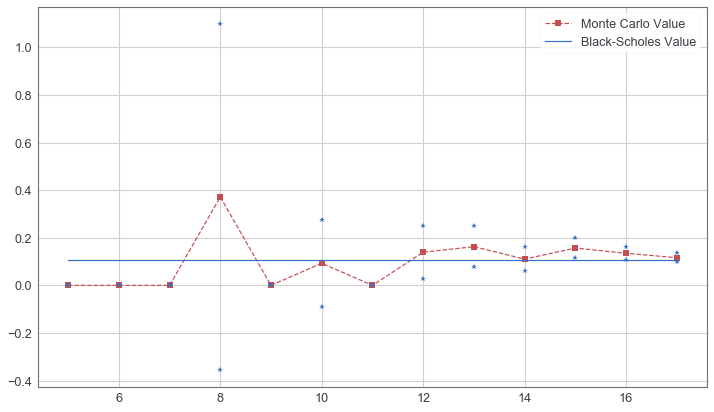

Black-Scholes Value :  0.10836847174610062
Monte Carlo Value :  0.11611687310799731


In [37]:
M = 2 ** (np.array(range(13)) + 5)
Exp = np.array(range(13)) + 5
# Calculate B-S Call Delta
true_value = np.ones(13) * bs_cash_or_nothing(Rate, Price, Strike, Time, sigma, pay_off)[2] 

V_ave = []
V_se = []
for i in M:
    
    Z = np.random.randn(i)
    S = Price * np.exp((mu - 0.5 * sigma * sigma ) * Time + sigma * np.sqrt(Time) * Z) # using same random number generator
    Sh = (Price + h) * np.exp((mu - 0.5 * sigma * sigma ) * Time + sigma * np.sqrt(Time) * Z) # using same random number generator
    diff = S - Strike
    diff[np.where(diff==0)] = pay_off / 2
    diff[np.where(diff<0)] = 0
    diff[np.where(diff>0)] = pay_off
    V = np.exp(-Rate * Time) * diff
    
    diff = Sh - Strike
    diff[np.where(diff==0)] = pay_off / 2
    diff[np.where(diff<0)] = 0
    diff[np.where(diff>0)] = pay_off
    Vh = np.exp(-Rate * Time) * diff
    
    diff = (Vh - V)/h
    
    V_ave.append(diff.mean())
    V_se.append(diff.std()/np.sqrt(i))
    

V_ave = np.array(V_ave)
V_se = np.array(V_se)

plt.figure(figsize=(12,7))
plt.plot(Exp, V_ave, '--rs', label = 'Monte Carlo Value')
plt.plot(Exp, V_ave + 1.96*V_se, '*b' )
plt.plot(Exp, V_ave - 1.96*V_se, '*b')
plt.plot(Exp, true_value, label='Black-Scholes Value')
plt.legend()
plt.show() 

print('Black-Scholes Value : ', true_value[0])
print('Monte Carlo Value : ', V_ave[-1])

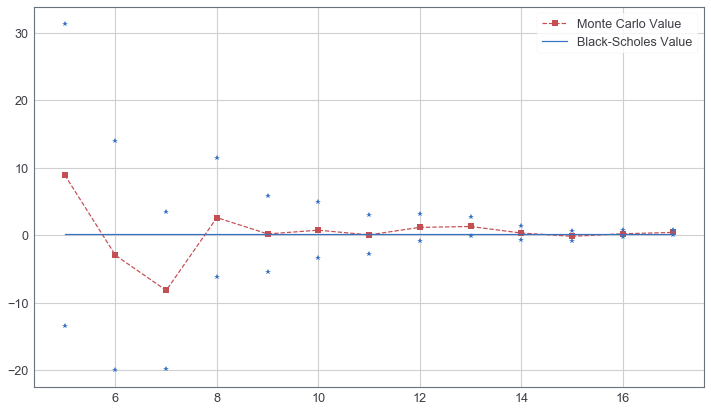

Black-Scholes Value :  0.10836847174610062
Monte Carlo Value :  0.4122148995333904


In [33]:
M = 2 ** (np.array(range(13)) + 5)
Exp = np.array(range(13)) + 5
# Calculate B-S Call Delta
true_value = np.ones(13) * bs_cash_or_nothing(Rate, Price, Strike, Time, sigma, pay_off)[2] 

V_ave = []
V_se = []
for i in M:
    
    Z_1 = np.random.randn(i)
    Z_2 = np.random.randn(i)
    S = Price * np.exp((mu - 0.5 * sigma * sigma ) * Time + sigma * np.sqrt(Time) * Z_1) # using different generator
    Sh = (Price + h) * np.exp((mu - 0.5 * sigma * sigma ) * Time + sigma * np.sqrt(Time) * Z_2) # using different generator
    diff = S - Strike
    diff[np.where(diff==0)] = pay_off / 2
    diff[np.where(diff<0)] = 0
    diff[np.where(diff>0)] = pay_off
    V = np.exp(-Rate * Time) * diff
    
    diff = Sh - Strike
    diff[np.where(diff==0)] = pay_off / 2
    diff[np.where(diff<0)] = 0
    diff[np.where(diff>0)] = pay_off
    Vh = np.exp(-Rate * Time) * diff
    
    diff = (Vh - V)/h
    
    V_ave.append(diff.mean())
    V_se.append(diff.std()/np.sqrt(i))
    

V_ave = np.array(V_ave)
V_se = np.array(V_se)

plt.figure(figsize=(12,7))
plt.plot(Exp, V_ave, '--rs', label = 'Monte Carlo Value')
plt.plot(Exp, V_ave + 1.96*V_se, '*b' )
plt.plot(Exp, V_ave - 1.96*V_se, '*b')
plt.plot(Exp, true_value, label='Black-Scholes Value')
plt.legend()
plt.show() 

print('Black-Scholes Value : ', true_value[0])
print('Monte Carlo Value : ', V_ave[-1])

### If we use different random number generator there are huge difference and variance.

# Homework 7

In [55]:
Rate = 0.05
Price = 10
Strike = 10
Time = 1
sigma = 0.35
L = 12 
time_line = np.linspace(0,Time,L)
dt = (Time) / L # unit size of time_step interval

## Arithmetic Average Asian Put Option

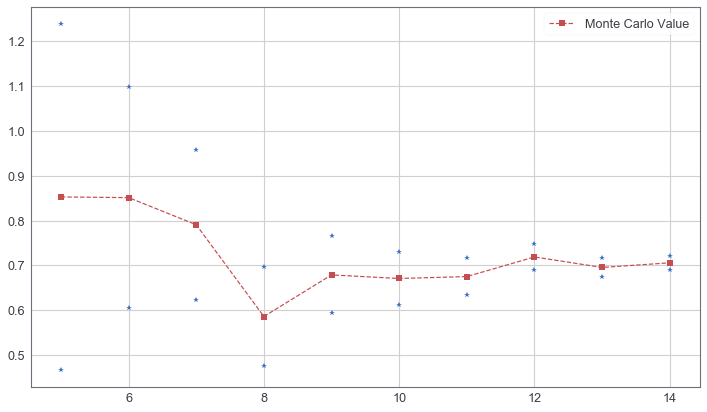

In [62]:
M = 2 ** (np.array(range(10)) + 5)
Exp = np.array(range(10)) + 5

V_ave = []
V_se = []

for i in M:
    
    paths=pd.DataFrame(np.ones(i)*Price)
    
    for j in range(12): # M(i) 개의 path 동시에 생성
        paths[j+1] = paths[j].apply(lambda x : x* np.exp((Rate - 0.5 * sigma * sigma ) * dt + sigma * np.sqrt(dt) * np.random.randn()))
    
    
    final_value = (paths.sum(axis=1) - Price) / 12 # using arithmetic mean
    V = final_value.apply(lambda x : max(np.exp(-Rate * Time) * (Strike-x),0)) # M(i) 개의 final_value 들에 대한 put value 계산
                 
  
    V_ave.append(V.mean())
    V_se.append(V.std()/np.sqrt(i))
    

V_ave = np.array(V_ave)
V_se = np.array(V_se)

plt.figure(figsize=(12,7))
plt.plot(Exp, V_ave, '--rs', label = 'Monte Carlo Value')
plt.plot(Exp, V_ave + 1.96*V_se, '*b' )
plt.plot(Exp, V_ave - 1.96*V_se, '*b')
plt.legend()
plt.show() 

## Geometric Average Asian Call Option

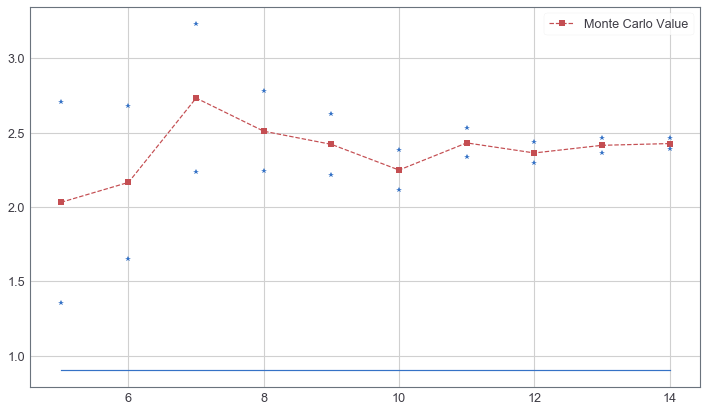

In [66]:
M = 2 ** (np.array(range(10)) + 5)
Exp = np.array(range(10)) + 5

V_ave = []
V_se = []
asian_geo_Call = BSGeoAsianCallPut_fun(Rate, Price, Strike, Time, sigma, L)[0]

for i in M:
    
    paths=pd.DataFrame(np.ones(i)*Price)
    
    for j in range(12): # M(i) 개의 path 동시에 생성
        paths[j+1] = paths[j].apply(lambda x : x* np.exp((Rate - 0.5 * sigma * sigma ) * dt + sigma * np.sqrt(dt) * np.random.randn()))
    
    
    final_value = (paths[1:].prod(axis=1)-Price) ** (1/12) # using geometric mean
    V = final_value.apply(lambda x : max(np.exp(-Rate * Time) * (x-Strike),0)) # M(i) 개의 final_value 들에 대한 put value 계산
                 
  
    V_ave.append(V.mean())
    V_se.append(V.std()/np.sqrt(i))
    

V_ave = np.array(V_ave)
V_se = np.array(V_se)

plt.figure(figsize=(12,7))
plt.plot(Exp, V_ave, '--rs', label = 'Monte Carlo Value')
plt.plot(Exp, V_ave + 1.96*V_se, '*b' )
plt.plot(Exp, V_ave - 1.96*V_se, '*b')
plt.plot(Exp, asian_geo_Call * np.ones(10))

plt.legend()
plt.show() 

## Up-and-In barrier call

In [7]:
B=8

<img src = "https://trello-attachments.s3.amazonaws.com/5b29ec749cfb0d90ada47d03/5beedfbcc254ef85f1b46b5d/8a53127e1c387c0b64fa85ecab74481f/image.png">

In [13]:
d_1 = (np.log(Price/Strike) + (Rate + 0.5 * sigma * sigma)*Time)/(sigma*np.sqrt(Time))
d_2 = d_1 - sigma * np.sqrt(Time)

In [14]:
e_1 = (np.log(Price/B) + (Rate+0.5*sigma*sigma)*Time) / sigma * np.sqrt(Time)
e_1

-1.2500120974857853

In [15]:
e_2 = (np.log(Price/B) + (Rate-0.5*sigma*sigma)*Time) / sigma * np.sqrt(Time)
e_2

-1.5500120974857854

In [16]:
f_1 = (np.log(Price/B) - (Rate-0.5*sigma*sigma)*Time) / sigma * np.sqrt(Time)
f_1

-1.5833454308191186

In [17]:
f_2 = (np.log(Price/B) - (Rate+0.5*sigma*sigma)*Time) / sigma * np.sqrt(Time)
f_2

-1.8833454308191186

In [18]:
g_1 = (np.log(Price * Strike/B**2) - (Rate-0.5*sigma*sigma)*Time) / sigma * np.sqrt(Time)
g_1

-2.542285672325055

In [19]:
g_2 = (np.log(Price * Strike/B**2) - (Rate+0.5*sigma*sigma)*Time) / sigma * np.sqrt(Time)
g_2

-2.842285672325055

<img src = "https://trello-attachments.s3.amazonaws.com/5b29ec749cfb0d90ada47d03/5beedfbcc254ef85f1b46b5d/bf214002c19daff6ca0aab3447da5d1f/image.png">

In [20]:
a = Price*(norm.cdf(d_1) - norm.cdf(e_1) - (B/Price)**(1+2*Rate / sigma**2) * (norm.cdf(f_2) - norm.cdf(g_2)))
a

1.0272060269691115

In [21]:
b = Strike * np.exp(-Rate * Time) * (norm.cdf(d_2) - norm.cdf(e_2) - (B/Price)**(-1+2*Rate / sigma**2) * (norm.cdf(f_1) - norm.cdf(g_1)))
b

0.9289268903008

In [22]:
call_price = bs_call_put(Rate, Price, Strike, Time, sigma)[0] # Calculated B-S Call Option Value

In [23]:
up_and_out_call = a - b
up_and_in_call = call_price - up_and_out_call

In [24]:
up_and_in_call

0.2469207408786268

In [6]:
Rate = 0.05
Price = 5
Strike = 6
Time = 1
sigma = 0.3
B=8

In [7]:
def get_value(series): # One Path 를 입력받아 up-and-in 을 판단하여 value 를 return 하는 함수
    if series.max() > B:
        return max(np.exp(-Rate * Time) * (list(series)[-1]-Strike),0)
    else:
        return 0

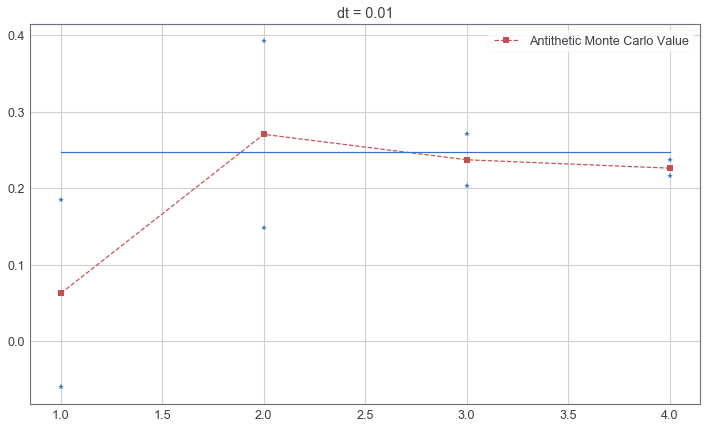

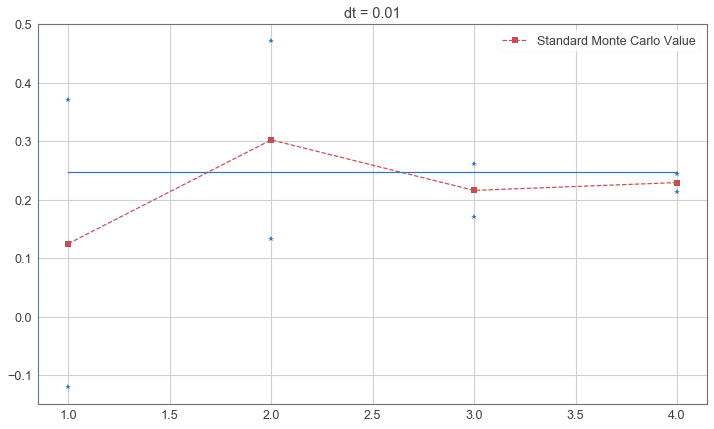

ratio
2.0
1.3846926288591828
1.3122846978504406
1.4366803403286916


In [26]:
M = 10 ** (np.array(range(4)) + 1)
Exp = np.array(range(4)) + 1
time_steps = [1e-2]
   
for dt in time_steps:
    V_ave = []
    V_se = []
    standard_mc_ave = []
    standard_mc_se = []
    L = int(Time / dt) # number of time_step interval

    
    for i in M:
        paths=pd.DataFrame(np.ones(i)*Price)
        paths_2=pd.DataFrame(np.ones(i)*Price)

        for j in range(L-1): # M(i) 개의 path 동시에 생성
            paths[j+1] = paths[j].apply(lambda x : x* np.exp((Rate - 0.5 * sigma * sigma ) * dt + sigma * np.sqrt(dt) * np.random.randn()))
            paths_2[j+1] = paths_2[j].apply(lambda x : x* np.exp((Rate - 0.5 * sigma * sigma ) * dt - sigma * np.sqrt(dt) * np.random.randn()))


        V = paths.apply(get_value, axis=1) # get_value 함수를 통해 M(i) 개의 value 계산
        V_2 = paths_2.apply(get_value, axis=1) # get_value 함수를 통해 M(i) 개의 value 계산

        V_hat = 0.5 * (V+V_2)
        standard_mc_ave.append(V.mean())
        standard_mc_se.append(V.std()/np.sqrt(i))
        V_ave.append(V_hat.mean())
        V_se.append((V_hat.std()/np.sqrt(i)))


    V_ave = np.array(V_ave)
    V_se = np.array(V_se)
    standard_mc_ave = np.array(standard_mc_ave)
    standard_mc_se = np.array(standard_mc_se)

    plt.figure(figsize=(12,7))
    plt.plot(Exp, V_ave, '--rs', label = 'Antithetic Monte Carlo Value')
    plt.plot(Exp, V_ave + 1.96*V_se, '*b' )
    plt.plot(Exp, V_ave - 1.96*V_se, '*b')
    plt.plot(Exp, up_and_in_call * np.ones(4))
    plt.title('dt = ' + str(dt))
    plt.legend()
    plt.show() 
    
    plt.figure(figsize=(12,7))
    plt.plot(Exp, standard_mc_ave, '--rs', label = 'Standard Monte Carlo Value')
    plt.plot(Exp, standard_mc_ave + 1.96*standard_mc_se, '*b' )
    plt.plot(Exp, standard_mc_ave - 1.96*standard_mc_se, '*b')
    plt.plot(Exp, up_and_in_call * np.ones(4))
    plt.title('dt = ' + str(dt))
    plt.legend()
    plt.show() 
    
    print('ratio')
    for i in range(4):
        print( standard_mc_se[i] / V_se[i])

In [52]:
Rate = 0.05
Price = 10
Strike = 10
Time = 1
sigma = 0.35
L = 12 
time_line = np.linspace(0,Time,L)
dt = (Time) / L # unit size of time_step interval

In [34]:
def bs_call_put(Rate, Price, Strike, Time, sigma):
    
    d1 = (np.log(Price/Strike) + (Rate + 0.5 * sigma * sigma)*Time)/(sigma*np.sqrt(Time));
    d2 = d1 - sigma * np.sqrt(Time);
    Call_Price = Price * norm.cdf(d1) - Strike * np.exp(-Rate * Time) * norm.cdf(d2);
    Put_Price = -Price * norm.cdf(-d1) + Strike * np.exp(-Rate * Time) * norm.cdf(-d2);
    CDelta = norm.cdf(d1);
    PDelta = norm.cdf(d1) - 1;
    
    return Call_Price, CDelta, Put_Price, PDelta

In [35]:
def BSGeoAsianCallPut_fun(Rate, Price, Strike, Time, sigma, Ave_num):

    Call = bs_call_put(Rate, Price, Strike, Time, sigma)[0]
    Put = bs_call_put(Rate, Price, Strike, Time, sigma)[2]
    
    sigma_hat = sigma / Ave_num * np.sqrt( (Ave_num + 1) * (2 * Ave_num + 1) / 6)
    mu_hat = (Rate - 0.5 * sigma * sigma) * (Ave_num + 1)/(2 * Ave_num) + 0.5 * sigma_hat * sigma_hat

    d1 = (np.log(Price/Strike) + (mu_hat + 0.5 * sigma_hat * sigma_hat)*Time)/(sigma_hat * np.sqrt(Time))
    d2 = d1 - sigma_hat * np.sqrt(Time)

    Call_Price = np.exp(-Rate * Time) * (Price * np.exp(mu_hat * Time) * norm.cdf(d1) - Strike * norm.cdf(d2))
    Put_Price = np.exp(-Rate * Time) * (-Price * np.exp(mu_hat * Time) * norm.cdf(-d1) + Strike * norm.cdf(-d2))
    
    return Call_Price, Put_Price

0.9038211800592608


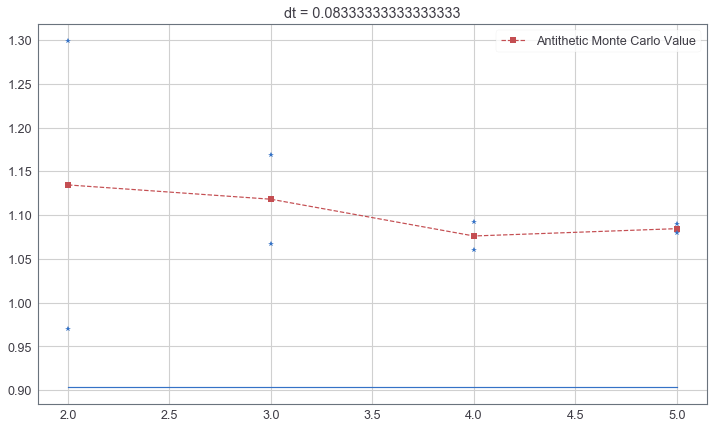

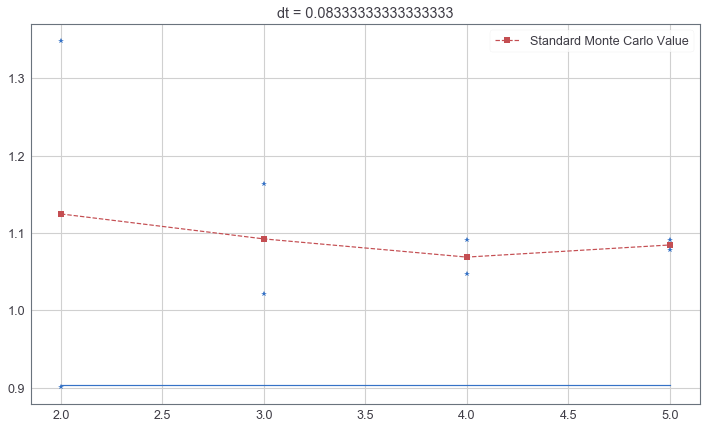

ratio
1.3599821649614727
1.3948516490024945
1.4221298180667086
1.4114319391341472


In [54]:
M = 10 ** (np.array(range(4)) + 2)
Exp = np.array(range(4)) + 2
   
asian_Call = BSGeoAsianCallPut_fun(Rate, Price, Strike, Time, sigma, 12)[0]
print(asian_Call)

V_ave = []
V_se = []
standard_mc_ave = []
standard_mc_se = []


for i in M:
    paths=pd.DataFrame(np.ones(i)*Price)
    paths_2=pd.DataFrame(np.ones(i)*Price)

    for j in range(L-1): # Monthly Averaging
        paths[j+1] = paths[j].apply(lambda x : x* np.exp((Rate - 0.5 * sigma * sigma ) * dt + sigma * np.sqrt(dt) * np.random.randn()))
        paths_2[j+1] = paths_2[j].apply(lambda x : x* np.exp((Rate - 0.5 * sigma * sigma ) * dt - sigma * np.sqrt(dt) * np.random.randn()))


    final_value = (paths.sum(axis=1) - Price) / L # using arithmetic mean
    V = final_value.apply(lambda x : max(np.exp(-Rate * Time) * (Strike-x),0)) # M(i) 개의 final_value 들에 대한 put value 계산
    final_value = (paths_2.sum(axis=1) - Price) / L # using arithmetic mean
    V_2 = final_value.apply(lambda x : max(np.exp(-Rate * Time) * (Strike-x),0)) # M(i) 개의 final_value 들에 대한 put value 계산



    V_hat = 0.5 * (V+V_2)
    standard_mc_ave.append(V.mean())
    standard_mc_se.append(V.std()/np.sqrt(i))
    V_ave.append(V_hat.mean())
    V_se.append((V_hat.std()/np.sqrt(i)))


V_ave = np.array(V_ave)
V_se = np.array(V_se)
standard_mc_ave = np.array(standard_mc_ave)
standard_mc_se = np.array(standard_mc_se)

plt.figure(figsize=(12,7))
plt.plot(Exp, V_ave, '--rs', label = 'Antithetic Monte Carlo Value')
plt.plot(Exp, V_ave + 1.96*V_se, '*b' )
plt.plot(Exp, V_ave - 1.96*V_se, '*b')
plt.plot(Exp, asian_Call * np.ones(4))
plt.title('dt = ' + str(dt))
plt.legend()
plt.show() 

plt.figure(figsize=(12,7))
plt.plot(Exp, standard_mc_ave, '--rs', label = 'Standard Monte Carlo Value')
plt.plot(Exp, standard_mc_ave + 1.96*standard_mc_se, '*b' )
plt.plot(Exp, standard_mc_ave - 1.96*standard_mc_se, '*b')
plt.plot(Exp, asian_Call * np.ones(4))
plt.title('dt = ' + str(dt))
plt.legend()
plt.show() 

print('ratio')
for i in range(4):
    print( standard_mc_se[i] / V_se[i])